### Part2 - Using the COCO dataset

In [11]:
# !pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable
  Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trdg 1.8.0 requires opencv-python>=4.2.0.32, which is not installed.


In [3]:
from pycocotools.coco import COCO

### Load the COCO dataset (cocotrain-2017)
we load the coc databse and then extract the id for cat and horse (17,19).\
Then we load the images for each category, to prevent overfiting we shuffle the data and divide them to train and test data.\
The next step is to add the label and Image into a datasource object and pass it to the model and train it.

In [4]:
coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=18.87s)
creating index...
index created!


In [5]:
cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")

In [6]:
horse_cat

[19]

In [24]:
cat_cat

[17]

In [28]:
cat_imgs = coco.getImgIds(catIds=cat_cat)
cat_imgs
horse_imgs = coco.getImgIds(catIds=horse_cat)

In [29]:
import random

random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:400]
cat_imgs_test = cat_imgs[400:600]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:400]
horse_imgs_test = horse_imgs[400:600]

In [70]:
cat_meta_train = coco.loadImgs(ids=cat_imgs_train)
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)
horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)

In [31]:
cat_meta_train

[{'license': 1,
  'file_name': '000000286414.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000286414.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 23:12:25',
  'flickr_url': 'http://farm1.staticflickr.com/188/438758347_355cc9b241_z.jpg',
  'id': 286414},
 {'license': 1,
  'file_name': '000000150235.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000150235.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-17 15:46:53',
  'flickr_url': 'http://farm5.staticflickr.com/4141/4867393383_b309c4d65b_z.jpg',
  'id': 150235},
 {'license': 3,
  'file_name': '000000355559.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000355559.jpg',
  'height': 333,
  'width': 500,
  'date_captured': '2013-11-14 16:20:48',
  'flickr_url': 'http://farm4.staticflickr.com/3040/3084813082_0b3e339e26_z.jpg',
  'id': 355559},
 {'license': 4,
  'file_name': '000000379165.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017

### Prepare Image 
##### Here we try to show an image and convert it to a PIL Image, to be aligned with the type we used in the first part

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/scratch/lt2316-h18-resources/coco/train2017/{}".format(cat_meta_train[0]['file_name']))


In [44]:
type(img)

numpy.ndarray

In [49]:
from PIL import Image
img2=Image.fromarray(img)

In [51]:
type(img2)

PIL.Image.Image

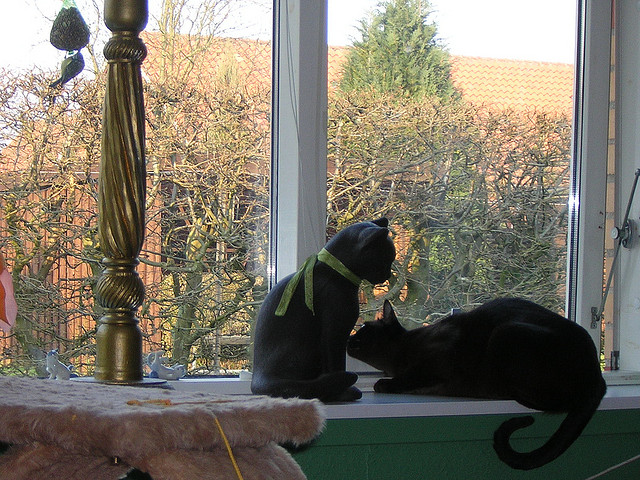

In [52]:
img2

##### The function will map the data in the format (Image,label) which is aligned with the data format has been used in the part1

In [95]:
def get_data(meta,label, datadir="/scratch/lt2316-h18-resources/coco/train2017"):
    return [( Image.open("{}/{}".format(datadir, x['file_name'])).resize((100,100)), label) for x in meta]

In [101]:
cat_data_train = get_data(cat_meta_train,cat_cat[0])
cat_data_train[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 17)

In [68]:
len(cat_data_train)

400

In [103]:
type(cat_data_train)

list

In [71]:
horse_data_train = get_data(horse_meta_train,horse_cat)
cat_data_test = get_data(cat_meta_test,cat_cat)
horse_data_test = get_data(horse_meta_test,horse_cat)

In [107]:
cat_data_train[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 17)

### After data preparation the steps are:

In [108]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [109]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [110]:
cat_data_train= cat_data_train.with_transform(transforms)

AttributeError: 'list' object has no attribute 'with_transform'

### The train_data format is List
But it should be converted to Dataset to be able to apply the transfrom function on them       

##### <span style="color:red"> Kind of stoped here for now, getting an error when want concvert the list into datset<span> 
by finishing this the part 2 is done

In [ ]:
from datasets import Dataset
Dataset.from_list(cat_data_train)

In [120]:
type(cat_data_train)

list

In [117]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:50]")

In [3]:
food = food.train_test_split(test_size=0.2)

In [114]:
type(food["train"])

datasets.arrow_dataset.Dataset

In [4]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 6}

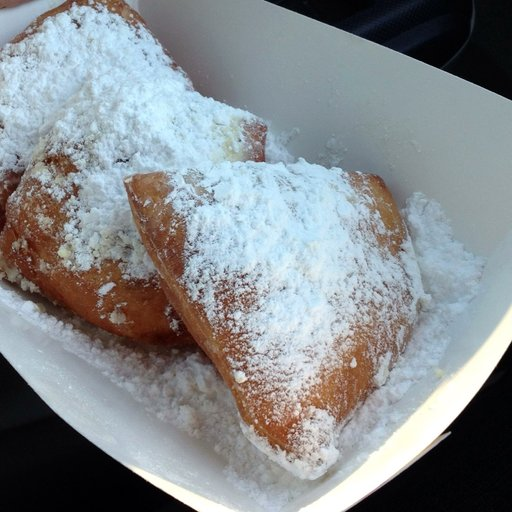

In [43]:
food["train"][0]['image']

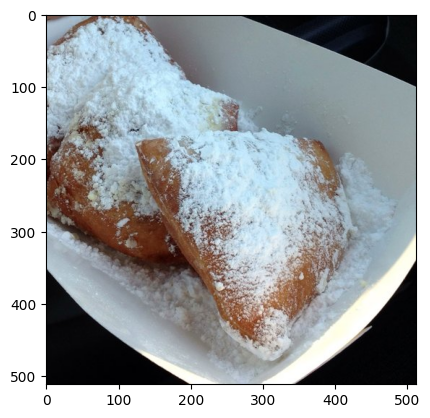

In [40]:
plt.imshow(food["train"][0]['image'])

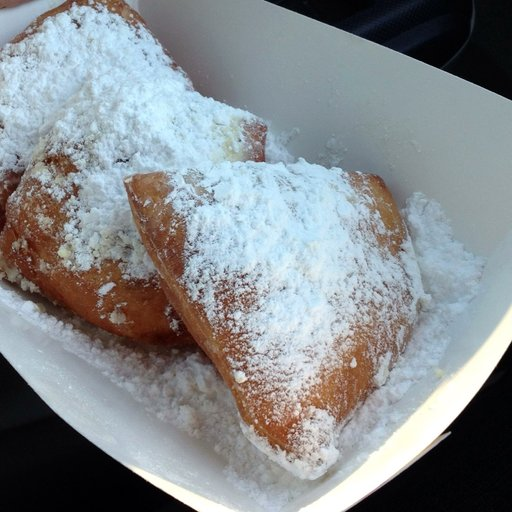

In [36]:
food["train"][0]['image']

In [20]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [21]:
id2label[str(79)]

'prime_rib'

In [55]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [56]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [57]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    print(examples)
    return examples

In [59]:
food = food.with_transform(transforms)
# food

In [65]:
food['train'].features['image']

Image(decode=True, id=None)

In [26]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [27]:
# pip install  evaluate
# !pip install transformers datasets
# !pip install accelerate -U

In [28]:
import evaluate

accuracy = evaluate.load("accuracy")

In [29]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [30]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib64/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,4.459400,3.806423,0.619000
1,3.416900,3.272887,0.824000
2,3.196900,3.137354,0.826000


/usr/local/lib64/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib64/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=45, training_loss=3.6626409530639648, metrics={'train_runtime': 589.2619, 'train_samples_per_second': 20.364, 'train_steps_per_second': 0.076, 'total_flos': 8.885359370797056e+17, 'train_loss': 3.6626409530639648, 'epoch': 2.86})

In [33]:
pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [41]:
model.save_pretrained('.')

In [34]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

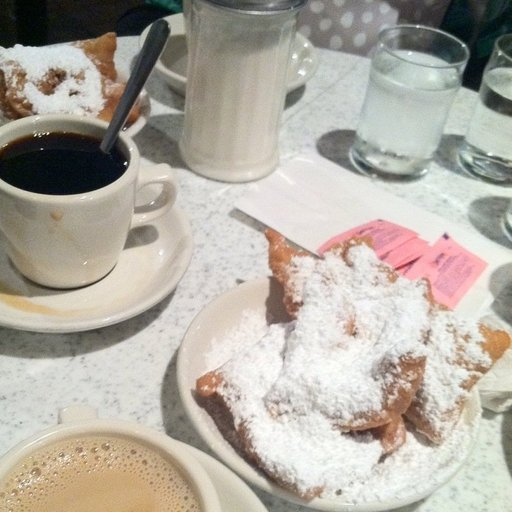

In [35]:
image

In [53]:
from transformers import pipeline
modelPath="/home/gusmankae@GU.GU.SE/my_awesome_food_model/checkpoint-45"

classifier = pipeline("image-classification", model=modelPath)
classifier(image)

[{'score': 0.02350117452442646, 'label': 'hamburger'},
 {'score': 0.021778635680675507, 'label': 'bruschetta'},
 {'score': 0.02155219577252865, 'label': 'beignets'},
 {'score': 0.021298348903656006, 'label': 'prime_rib'},
 {'score': 0.02062642201781273, 'label': 'chicken_wings'}]

In [63]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained(modelPath)
inputs = image_processor(image, return_tensors="pt")

In [64]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(modelPath)
with torch.no_grad():
    logits = model(**inputs).logits

In [65]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'